# Window trajectory

The goal of this notebook is to extract trajectories in topic space. 

* Author: jgyou <jyoung22@uvm.edu>
* Date: 12/21/2023
* License: MIT


In [124]:
import manifoldpy
from datetime import datetime
from collections.abc import Iterable
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import glob
import networkx as nx
import seaborn as sns
from sklearn.metrics import pairwise
from sklearn.metrics import DistanceMetric
from datetime import datetime

EMBEDDING_DIMS = 384

sns.set_style("ticks")

# Load topic location data

We load the embedding + topic clustering.

In [12]:
topic_mapping = pd.read_csv('../src/data/id_topic_mapping.csv')
topic_mapping

,id,topic,slug
0,ur6TqIqffxvUeULM5wIm,-1,who-will-finish-1st-in-leagues-s3-m-b43a24ed50c3
1,1sfbjcTu6zgqjCVjqWA2,38,will-the-lk99-room-temp-ambient-pre
2,GrfxPS8wLngFhacbsG4o,207,which-team-will-win-the-2023-fifa-w-9730308e083d
3,U3zLgOZkGUE7cvG98961,83,will-the-whales-win-this-market
4,Zk3pS09hFBuYrDL3kCKF,13,who-will-be-promoted-to-masters-fro
...,...,...,...
13433,HrqX8NlMEYtYJtOg97zm,-1,season-3-will-alexbgoode-stay-and-n
13434,91sTrf5g1DyaMv9eoeqi,52,will-interest-in-deepmind-overtake
13435,DqcO3ncl41HkAMsBo0K9,3,will-neuralink-announce-they-have-b
13436,DedTBUcFOD7KapwDbq1x,-1,will-there-be-an-ai-winter-between


In [306]:
with open('../src/data/topic_info_embeddings.json', 'r') as f:
    topic_embeddings = json.load(f)

# Distance function

In [42]:
n_topics = len(topic_embeddings['Topic'])

We construct the $236 \times 384$ matrix of topic centroids $\textbf{M}$.

In [44]:
M = np.zeros((n_topics, EMBEDDING_DIMS))

In [63]:
for t in range(n_topics):
    M[t, :] = topic_embeddings['topic_embeddings'][str(t)]

Now we define a function to return the closest topic

In [223]:
def closest_cendroid(x, M, metric='euclidean'):
    the_metric = DistanceMetric.get_metric(metric)
    return np.argmin(the_metric.pairwise(x.reshape(1, EMBEDDING_DIMS), M))

In [95]:
closest_cendroid(M[10, :], M, metric='euclidean')

10

# Load bets and markets

In [99]:
# glob code to load all bets 
joined_files = os.path.join("../src/data/bets", "*.json") 
joined_list = glob.glob(joined_files) 
bets = pd.concat(map(pd.read_json, joined_list), ignore_index=True) 
bets

../src/data/bets/*.json


,id,fees,fills,isApi,amount,isAnte,shares,userId,outcome,isFilled,...,sharesByOutcome,isLiquidityProvision,challengeSlug,value,allBetAmounts,allOutcomeShares,dpmShares,comment,dpmWeight,probAverage
0,AxVG5dx3csJPGiIqc5kH,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 1, 'shares': 2.214643060864233, 't...",0.0,1.000000,False,2.214643,B4vKNylnJpQH2GZRGrg6gFKMEWB3,YES,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OkXvrMmH4CcOjoUBktWJ,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 100, 'shares': 154.3312204980939, ...",0.0,100.000000,False,154.331220,fSrex43BDjeneNZ4ZLfxllSb8b42,NO,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7YOEDNe4EkoAd8M2glHD,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...",NaN,NaN,-13.200825,False,-116.099108,zssVPLqijpVK2ZUriKKznMW2mhS2,YES,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TbSUuT5li1GP3Y5PTqK7,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...",NaN,NaN,-102.898284,False,-116.099108,zssVPLqijpVK2ZUriKKznMW2mhS2,NO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QjJT2YGZsIF14YSh0pDJ,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 60.95417730668658, 'shares': 70.68...",0.0,100.000000,False,116.099108,zssVPLqijpVK2ZUriKKznMW2mhS2,NO,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310594,Iarorx025uibKp3iaOrA,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 10.284981607833942, 'shares': 29.7...",0.0,0.000000,False,0.000000,cfz8q51Q6xdrRjBw1HdfmMlsmAz1,NO,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4310595,SW61HUZV8u4K7dyIqNhy,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 10, 'shares': 19.1020887124281, 't...",0.0,10.000000,False,19.102089,SMsr6cdlkifWQKaf4Msnx0Bz8BV2,YES,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4310596,0nrZGxbIOflU7S01LSg3,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 5.4438023126980735, 'shares': 31.1...",0.0,222.000000,False,1185.434976,x02kfgRxhnN5MoRxZyTBCYqf9em1,YES,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4310597,hW3equRzNbgeuwNaTNMv,"{'creatorFee': 0, 'platformFee': 0, 'liquidity...","[{'amount': 7.565724920492345, 'shares': 13.46...",1.0,7.565725,False,13.467541,BhNkw088bMNwIFF2Aq5Gg9NTPzz1,YES,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Note that the below function needs the global object "bets" to exist.
# (So we'd probably need to run a DB for this to be clean code with natural design patterns.)

def retrieveUserBets(userId=None, name=None):
    """Retrieve all the bets of a user by userId or name, prioritizing userId."""
    if userId is None and name is None:
        raise ValueError('Either userId or name must be provided')
    if userId is None and name:
        _userId = manifoldpy.api.get_user_by_name(name).id
    else:
        _userId = userId
    return bets[bets['userId'] == _userId]

In [260]:
def movingWindows(bets, resolution=100):
    times = bets['createdTime'].apply(lambda x: datetime.utcfromtimestamp(x / 1000))
    
    min_time = times.min()
    max_time = times.max()
    
    # divide time span into "resolution" time centers
    time_centers = np.linspace(min_time.timestamp(), max_time.timestamp(), resolution)
    time_centers = [datetime.utcfromtimestamp(t) for t in time_centers]
    
    deltaDays = (max_time.timestamp() - min_time.timestamp()) / resolution / 2
    # convert differences in ms to days
    deltaDays /= 60 * 60 * 24
    
    for t in time_centers:
        bets_in_window = bets[(t > times - pd.Timedelta(days=deltaDays)) & (t < times + pd.Timedelta(days=deltaDays))]
        yield t, bets_in_window


# Load market embeddings


In [190]:
market_text_data = pd.read_json('../src/data/market_text_data_with_embeddings.json')

# Create trajectories

In [262]:
def get_trajectory(userId=None, name=None, resolution=100):
    trajectory = []
    userBets = retrieveUserBets(userId, name)
    for t, betSets in movingWindows(userBets, resolution):
        tmp_df = pd.merge(betSets, market_text_data, left_on='contractId', right_on='id')
        # convert embeddings to numpy array
        tmp_df['embeddings'] = tmp_df['embeddings'].apply(np.array)
        # remove columns with na embeddings
        tmp_df = tmp_df[tmp_df['embeddings'].apply(lambda x: not np.isnan(x).any())]
        if len(tmp_df) > 0:
            mean_embedding = np.mean(tmp_df['embeddings'])
            loc = closest_cendroid(mean_embedding, M, metric='euclidean')
            trajectory.append((t.strftime("%m-%d-%Y"), len(betSets), loc))
        else:
            trajectory.append((t.strftime("%m-%d-%Y"), 0, None))
    return trajectory

In [263]:
def thin_trajectory(trajectory):
    currentNode = None
    for t in range(len(trajectory)):
        if trajectory[t][2] is not None:
            currentNode = trajectory[t][2]
            break
    nextNode = None
    for t in range(t + 1, len(trajectory)):
        if trajectory[t][2] is not None:
            nextNode = trajectory[t][2]
            break
    edges = [(currentNode, nextNode)]
    for t in range(t + 1, len(trajectory)):
        if trajectory[t][2] is not None:
            currentNode = nextNode
            nextNode = trajectory[t][2]
            edges.append((currentNode, nextNode))
    return edges
    
    

In [406]:
trajectory = get_trajectory(name='Gen', resolution=100)


In [407]:
edges = thin_trajectory(trajectory)

In [408]:
# convert topics to 2d coordinates with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(M)
M_2d = pca.transform(M)

pos = {i: M_2d[i, :] for i in range(n_topics)}

In [409]:
topic_embeddings_dict = {int(k): v for k, v in topic_embeddings['Name'].items()}

In [410]:
import matplotlib as mpl
import matplotlib.cm as cm
   
norm = mpl.colors.Normalize(vmin=0, vmax=len(edges))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)


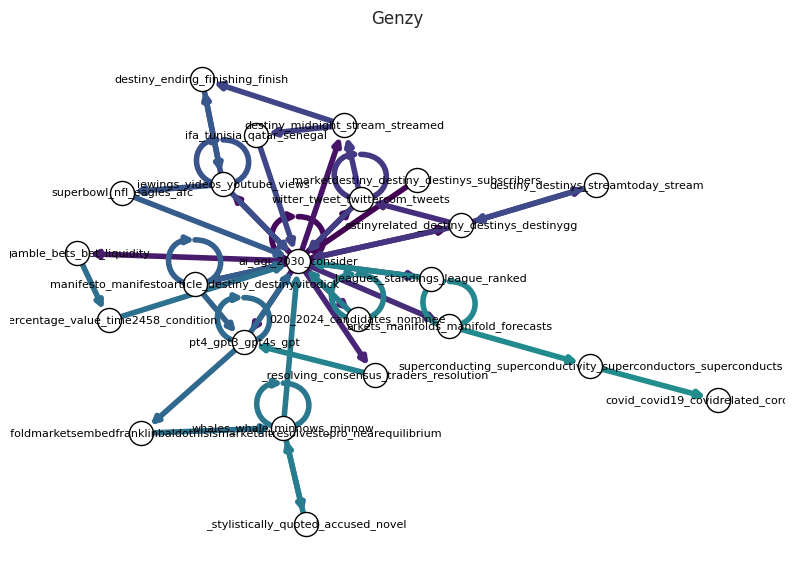

In [412]:
plt.figure(figsize=(10, 7))
g = nx.DiGraph(edges)
edge_att = {e: t for t, e in enumerate(edges)}
# nx.set_edge_attributes('time', edge_att)
plt.title('Genzy')
pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos=pos, edge_color=[m.to_rgba(t) for t in range(len(edges))], connectionstyle="arc3", node_color='w', edgecolors='k', linewidths=1, width=4)
nx.draw_networkx_labels(g, pos, labels={k: v[3:] for k, v in topic_embeddings_dict.items() if k in g.nodes()}, font_size=8);